In [1]:
import numpy as np
from seisLM.data_pipeline.foreshock_aftershock_dataset import (
  create_foreshock_aftershock_datasets
)
from seisLM.data_pipeline.foreshock_aftershock_dataloaders import (
  prepare_foreshock_aftershock_dataloaders)
import pandas as pd
import matplotlib.pyplot as plt
from seisLM.utils.project_path import gitdir
NUM_CLASSES = 4

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import json
import ml_collections
import torch
from seisLM.model.task_specific.foreshock_aftershock_models import (
  Conv1DShockClassifierLit, Wav2vec2ShockClassifierLit)


model = Wav2vec2ShockClassifierLit.load_from_checkpoint(
  gitdir() + '/results/models/foreshock_aftershock_run/num_classes_9_seed_42_training_fraction_0.05_model_Wav2Vec2ForSequenceClassification_time_2024-09-09-23h-10m-06s/checkpoints/epoch=3-step=36.ckpt',
  
  )

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

In [2]:



def get_seisLM_config():
  config_path = gitdir() + '/seisLM/configs/foreshock_aftershock/seisLM_shock_classifier.json'
  with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
  config = ml_collections.ConfigDict(config)
  config.model_args.num_classes = NUM_CLASSES
  return config

config = get_seisLM_config()

model = Wav2vec2ShockClassifierLit(
  model_config=config.model_args,
  training_config=config.trainer_args,
  ).model

print('config', config)
# from seisLM.model.foundation import pretrained_models


# pretrained_model = pretrained_models.LitMultiDimWav2Vec2.load_from_checkpoint(
#     model.config.pretrained_ckpt_path
# ).model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model = model.eval()
loaders = prepare_foreshock_aftershock_dataloaders(
  num_classes=model.config.num_classes,
  **config.data_args
)



config data_args:
  amp_norm_axis: -1
  amp_norm_type: std
  batch_size: 32
  component_order: ZNE
  demean_axis: -1
  dimension_order: NCW
  event_split_method: temporal
  num_workers: 8
  seed: 42
  test_frac: 0.2
  train_frac: 0.7
  val_frac: 0.1
model_args:
  apply_input_magnitude_mask: true
  apply_spec_augment: false
  concat_downsampled_input: false
  freeze_base_model: false
  freeze_feature_encoder: false
  head_dropout_rate: 0.5
  head_type: linear
  num_classes: 4
  pool_type: mean
  pretrained_ckpt_path: /home/liu0003/Desktop/projects/seisLM/results/models/pretrained_seisLM/pretrain_config_layernorm_std_small_batch_6_datasets_42__2024-08-14-09h-06m-17s/checkpoints/last.ckpt
  use_weighted_layer_sum: true
model_name: Wav2Vec2ForSequenceClassification
trainer_args:
  accelerator: gpu
  devices: 2
  max_epochs: 10
  optimizer: adamw
  optimizer_args:
    lr: 0.001
    weight_decay: 0.5
  strategy: ddp
  unfreeze_base_at_epoch: 0
  warmup_frac_step: 0.0



Seed set to 42
Seed set to 42


In [3]:
iter_test = iter(loaders['test'])
input_values, y = next(iter_test)


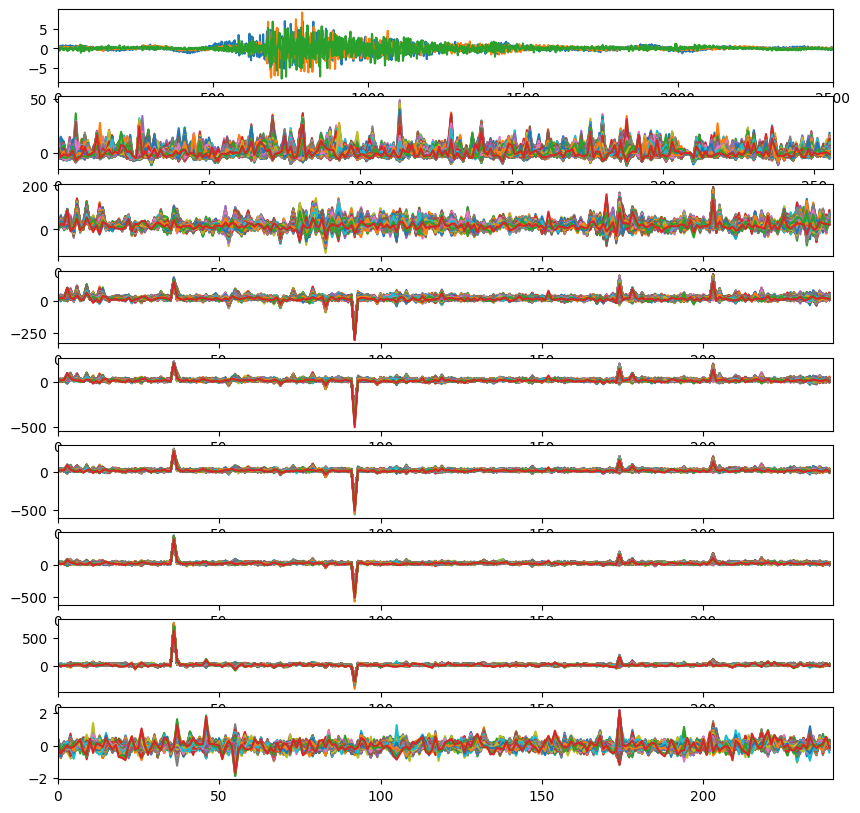

In [4]:

input_mask = torch.nn.functional.interpolate(
  input_values.abs().mean(axis=1, keepdim=True),
  size=240, mode='linear', align_corners=False)

# use_input_mask = True#False

with torch.no_grad():
  # hidden_states = model.get_wav2vec2_hidden_states(
  #   input_values.to(device),
  #   concat_downsampled_input=False
  # ).detach().cpu()

  wav2vec2_output = model.wav2vec2(
    input_values.to(device),
    output_hidden_states=True,
  )
  # last_hidden_state = wav2vec2_output.last_hidden_state.detach().cpu()
  extract_features = wav2vec2_output.extract_features.detach().cpu()
  all_hidden_states = wav2vec2_output.hidden_states


fig, axes = plt.subplots(
  2 + len(all_hidden_states), 1, figsize=(10, 10),
  # sharey='all'
)
axes[0].plot(input_values[0].T);
axes[0].set_xlim(0, 2500)

axes[1].plot(extract_features[0].T);
axes[1].set_xlim(0, extract_features.shape[-1])

for i, hidden_state in enumerate(all_hidden_states):
  hidden_state = hidden_state.detach().cpu()
  axes[i+2].plot(hidden_state[0].T);
  axes[i+2].set_xlim(0, hidden_state.shape[-1])



(0.0, 240.0)

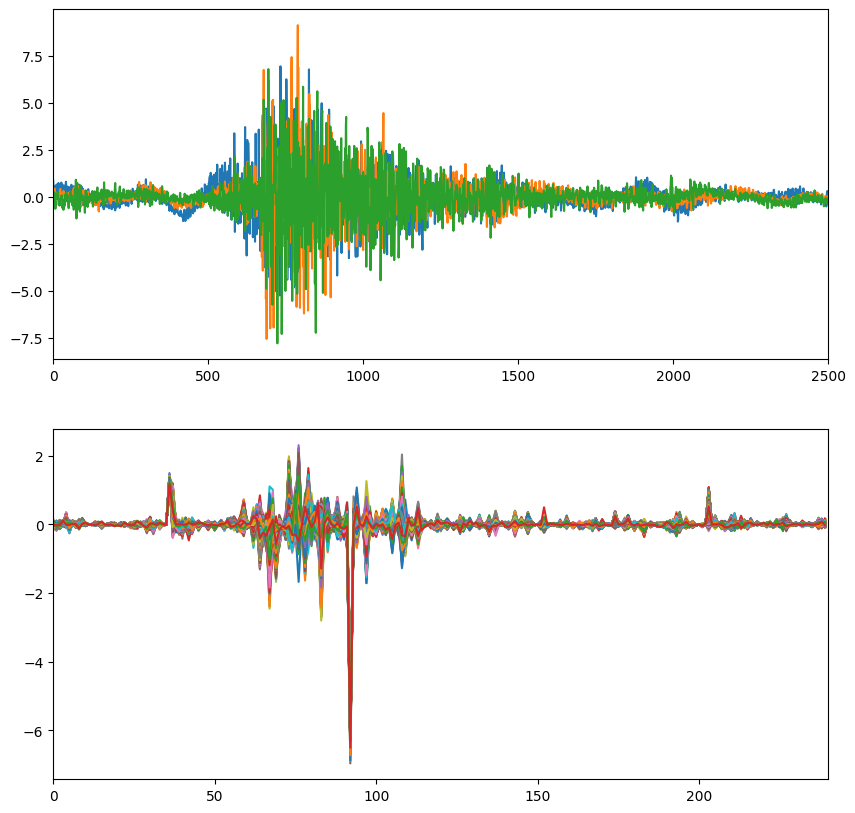

In [5]:

input_mask = torch.nn.functional.interpolate(
  input_values.abs().mean(axis=1, keepdim=True),
  size=240, mode='linear', align_corners=False)

# use_input_mask = True#False
# use_input_mask = False

with torch.no_grad():
  hidden_states = model.get_wav2vec2_hidden_states(
    input_values.to(device),
    concat_downsampled_input=False
  ).detach().cpu()

# if use_input_mask:
#   hidden_states = hidden_states * input_mask

fig, axes = plt.subplots(2, 1, figsize=(10, 10),
  # sharey='all'
)
axes[0].plot(input_values[0].T);
axes[0].set_xlim(0, 2500)

axes[1].plot(hidden_states[0].T);
axes[1].set_xlim(0, hidden_states.shape[-1])


In [6]:
dir(wav2vec2_output)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'attentions',
 'extract_features',
 'hidden_states',
 'last_hidden_state']

In [7]:
wav2vec2_output.hidden_states

(tensor([[[ -3.5529,  24.6413,  15.8862,  ..., -15.0710,  26.2286,  19.7951],
          [  6.6840,  19.2634,  23.8560,  ...,  37.0569,   2.5930,  35.5080],
          [  4.3910,  23.7906,  14.0513,  ...,  31.8714,   9.6580,  28.0283],
          ...,
          [ 11.8162,  26.4526,  25.0408,  ...,  33.4281,  22.2258,  33.0273],
          [ 15.7785,   7.9871,  32.5027,  ...,  71.5636,  -1.9651,  35.8246],
          [  7.2345,  25.1770,  18.7888,  ...,  27.5734,  24.1372,  21.9710]],
 
         [[ -1.1166,  18.6934,  15.3256,  ...,  35.6558,  20.6799,  34.2805],
          [ -5.8288,  16.0686,  22.6410,  ...,  25.8854,  20.5743,  31.2710],
          [-10.1405,  23.6803,  16.3137,  ...,  47.9852,   4.2617,  41.0745],
          ...,
          [ 12.1953,  14.8371,  22.6047,  ...,  30.2842,  16.6525,  34.7982],
          [ -0.1982,  13.7071,  23.7760,  ...,  28.1512,  12.0333,  40.7413],
          [  0.5957,  15.1742,  37.3157,  ...,  14.8828,  28.1889,  23.1924]],
 
         [[ 10.6449,  28.481

In [8]:
hidden_states.shape

torch.Size([32, 624, 240])

In [9]:
hidden_states[0]

tensor([[-2.7927e-02, -1.1356e-02,  2.7391e-02,  ..., -9.4633e-02,
          7.1236e-02,  1.6016e-03],
        [-4.1511e-02, -8.0232e-02,  4.8863e-02,  ..., -5.0088e-02,
          7.7603e-02, -1.1742e-02],
        [-2.6489e-02, -1.3259e-01,  2.7252e-03,  ..., -1.4263e-02,
          4.6406e-02,  1.0362e-02],
        ...,
        [ 4.8677e-02, -1.2259e-02,  2.5713e-02,  ..., -4.8502e-02,
          5.2871e-02,  3.4071e-05],
        [ 7.7384e-02, -8.7711e-02,  6.7571e-02,  ...,  6.6342e-02,
          3.7764e-02,  4.6234e-02],
        [-9.7459e-03, -2.3118e-02, -1.4693e-02,  ...,  1.0717e-02,
          9.2947e-02, -2.9816e-02]])

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


all_gt_class = []
all_pred_class = []
all_losses = []

model = model.to(device)
model.eval()

for X, y in loaders['test']:
  with torch.no_grad():
    logits = model(X.to(device)).cpu()
    pred_class = np.argmax(logits.numpy(), axis=1)
    loss = torch.nn.functional.cross_entropy(logits, y)
    all_losses.append(loss.item())

  all_gt_class.append(y)
  all_pred_class.append(pred_class)

all_gt_class = np.concatenate(all_gt_class)
all_pred_class = np.concatenate(all_pred_class)


cm = confusion_matrix(all_gt_class, all_pred_class)
cm_percentage = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
disp.plot()

AttributeError: attribute 'shape' of 'torch._C.TensorBase' objects is not writable